In [2]:
# SET UP
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, models
import time

In [3]:
# LOAD DATA
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# TRAIN_IMAGES HAVE THE SHAPE (NONE, 28,28). WE NEED TO EXPAND DIMS OF TRAIN_IMAGES BEFOR TRAINING
train_images = np.expand_dims(train_images, axis = -1)
train_labels = np.expand_dims(train_labels, axis = -1)

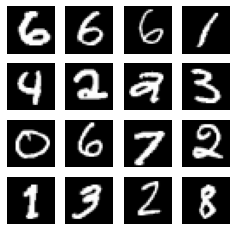

In [5]:
# SHOW SOME IMAGES
examples = np.random.randint(0, train_images.shape[0],16)
plt.figure(figsize= (4,4))
for i in range(len(examples)):
    plt.subplot(4,4,i+1)
    x = examples[i]
    plt.imshow(train_images[x,:,:,0], cmap ="gray")
    plt.axis("off")
plt.show()
        

In [6]:
# PREB DATA
# Normalize to [-1,1]
train_images = (train_images.astype("float32") - 127.5)/127.5

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128
# Data pipeline
train_data = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

In [7]:
# Create model
# Generator
# The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise)
# Start with a Dense layer that takes this seed as input
# then upsample several times until you reach the desired image size of 28x28x1
# The final layer has "tanh" activation because we want our matrix has its values in [-1,1]
# the generator model does not use bias
def generator():
    inp = layers.Input((100,)) 
    label = layers.Input((1,))
    x = layers.Embedding(10,10, input_length = 1, name  = "emb" )(label)
    x = layers.Flatten()(x)
    x = layers.concatenate([inp, x])
    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    # output 7*7*256
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # output 7*7*128
    
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # output 14*14*64
    
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    #output 28*28*1
    model = models.Model([inp, label], x)
    
    model.summary()
    return model
generator = generator()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb (Embedding)                 (None, 1, 10)        100         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 10)           0           emb[0][0]                        
______________________________________________________________________________________________

In [8]:
# Discriminator
def discriminator():
    image = layers.Input((28,28,1))
    label = layers.Input((1,))
    x = layers.Embedding(20, 28*28,input_length = 1)(label)
    x = layers.Reshape((28,28,1))(x)
    x = layers.concatenate([image, x])
    x = layers.Conv2D(64, kernel_size = (5,5), strides = 2, padding = "same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    # output 14*14*64
    
    x = layers.Conv2D(128, kernel_size = (5,5), strides = 2, padding ="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    # output 7*7*128
    
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x) # logit
    model = models.Model([image, label],x)
    
    model.summary()
    return model
discriminator = discriminator()
    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 784)       15680       input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           embedding[0][0]                  
____________________________________________________________________________________________

In [9]:
# loss and optimizer
# Version 1 use logit, version 2 use Probability
# This method returns a helper function to compute cross entropy loss for logits
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# disc loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
# gen loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# optimizer
lr = tf.Variable(0.0002)
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [10]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
# seed ~ N(0,1)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
labs = tf.cast(10*tf.random.uniform((16,)), tf.int32)

In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    labs = tf.cast(10*tf.random.uniform((128,)), tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   
        generated_images = generator([noise,labs], training=True)
        real_output = discriminator([images[0], images[1]], training=True)
        fake_output = discriminator([generated_images, labs], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss
def train(dataset, epochs):
    all_gl = np.array([]); all_dl = np.array([])
    for epoch in range(epochs):
        start = time.time()
        gen_loss = []
        disc_loss = []

        for image_batch in dataset:
            x,y = train_step(image_batch)
            gen_loss.append(x)
            disc_loss.append(y)
        all_gl = np.append(all_gl,np.array([gen_loss]))
        all_dl = np.append(all_dl,np.array([disc_loss]))
        if epoch%5==0:
            # PLOT EPOCH LOSS
            plt.figure(figsize=(16,2))
            plt.plot(np.arange(len(gen_loss)),gen_loss,label='Gen_loss')
            plt.plot(np.arange(len(disc_loss)),disc_loss,label='Disc_loss')
            plt.legend()
            plt.title('Epoch '+str(epoch)+' Loss')
            ymax = plt.ylim()[1]
            plt.show()
            
            # PLOT ALL TIME LOSS
            plt.figure(figsize=(16,2))
            plt.plot(np.arange(len(all_gl)),all_gl,label='Gen_loss')
            plt.plot(np.arange(len(all_dl)),all_dl,label='Disc_loss')
            plt.legend()
            plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
            plt.title('All Time Loss')
            plt.show()

            # DISPLAY IMAGES FROM TRAIN PROGRESS
            seed = tf.random.normal([num_examples_to_generate, noise_dim])
            labs = tf.cast(10*tf.random.uniform((16,)), tf.int32)
            show_examples(generator, seed, labs)
            
            # PRINT STATS
            print('Gen_loss mean=',np.mean(gen_loss),'std=',np.std(gen_loss))
            print('Disc_loss mean=',np.mean(disc_loss),'std=',np.std(disc_loss))
            print('Learning rate = ',end='')
            tf.print(discriminator_optimizer.lr)
def show_examples(model, seed, labs):
    
    preds = model([seed, labs], training = False)
    plt.figure(figsize = (4,4))
    for i in range(preds.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow((preds[i,:,:,0]+1.)/2.,cmap ="gray" )
        plt.axis("off")
    plt.show()

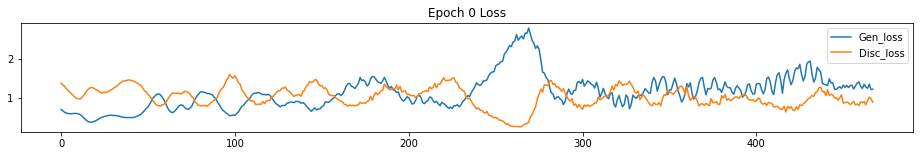

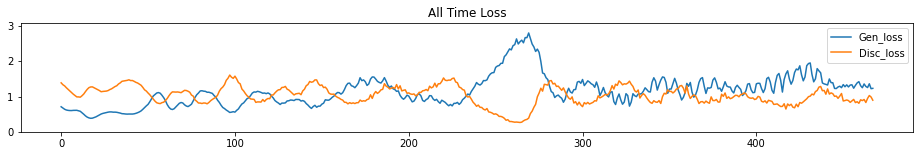

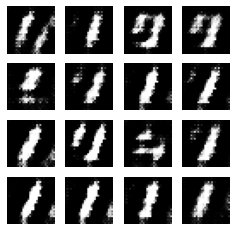

Gen_loss mean= 1.1496918 std= 0.43607822
Disc_loss mean= 1.0357841 std= 0.25868773
Learning rate = 0.0002


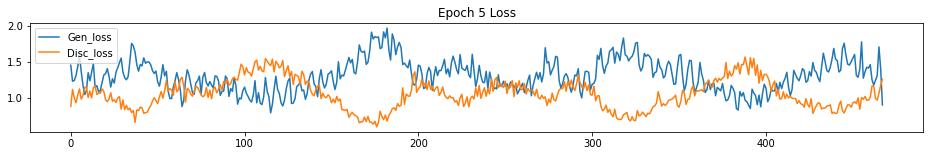

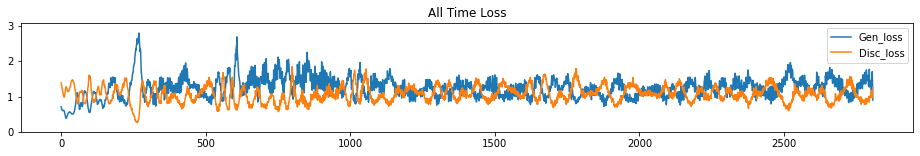

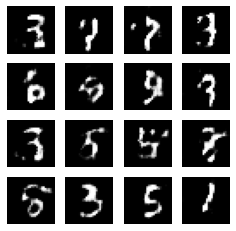

Gen_loss mean= 1.3047518 std= 0.21844731
Disc_loss mean= 1.05206 std= 0.20135802
Learning rate = 0.0002


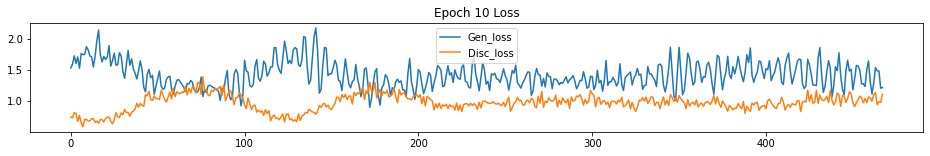

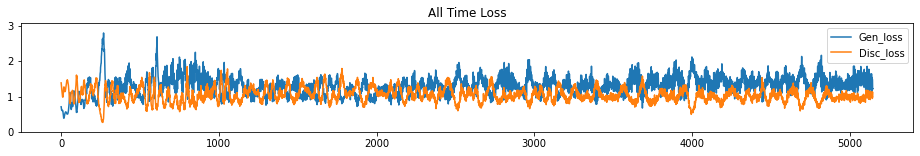

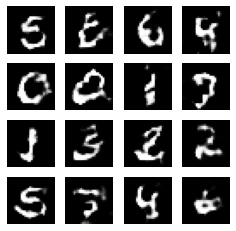

Gen_loss mean= 1.4212161 std= 0.20794268
Disc_loss mean= 0.9769343 std= 0.13154273
Learning rate = 0.0002


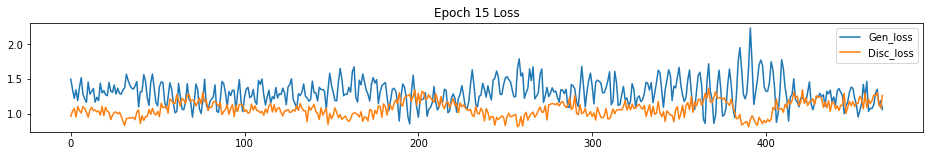

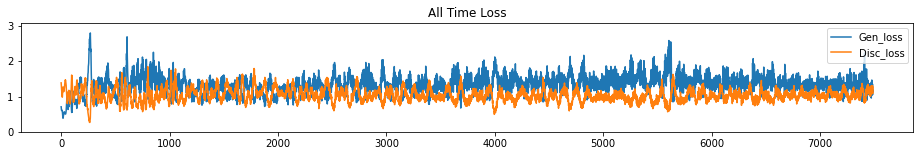

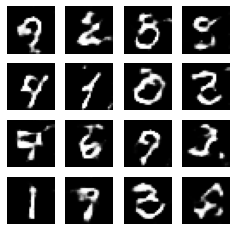

Gen_loss mean= 1.3092344 std= 0.18324587
Disc_loss mean= 1.0741993 std= 0.11041964
Learning rate = 0.0002


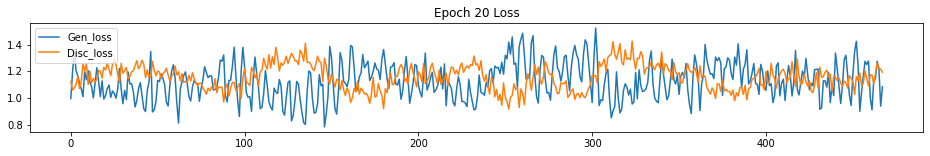

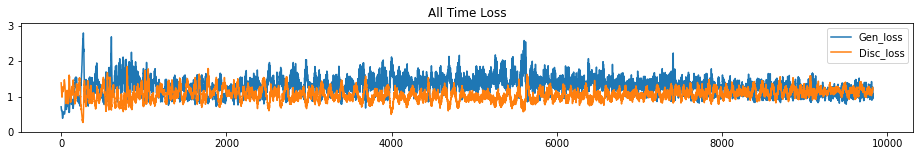

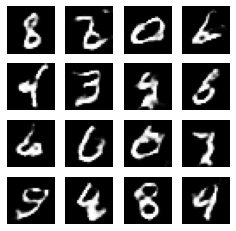

Gen_loss mean= 1.1269172 std= 0.13507456
Disc_loss mean= 1.1565635 std= 0.09156037
Learning rate = 0.0002


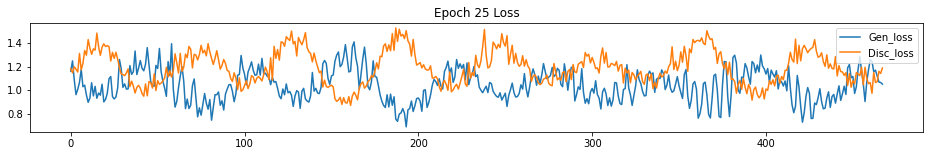

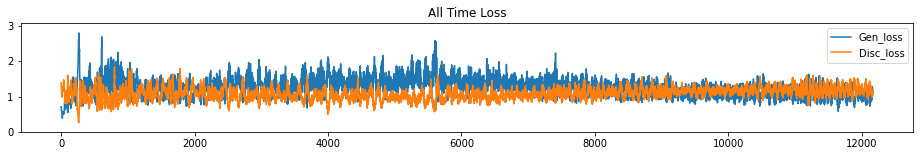

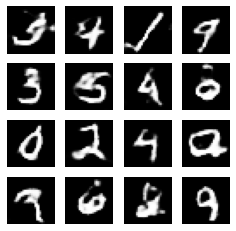

Gen_loss mean= 1.0427431 std= 0.13454397
Disc_loss mean= 1.1937858 std= 0.14140132
Learning rate = 0.0002


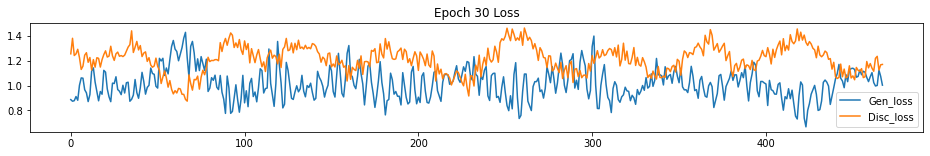

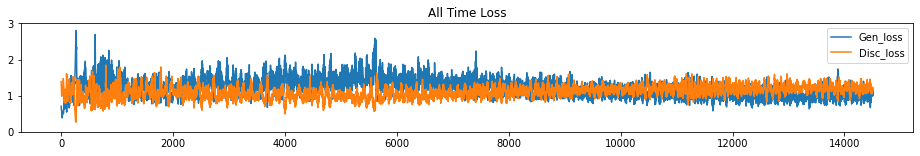

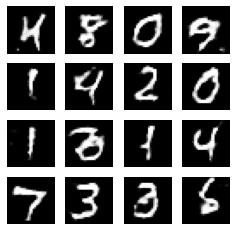

Gen_loss mean= 1.0162861 std= 0.123139806
Disc_loss mean= 1.2124399 std= 0.10872492
Learning rate = 0.0002


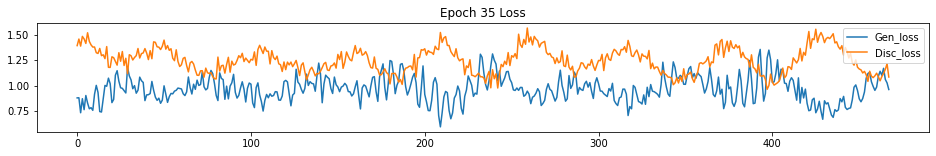

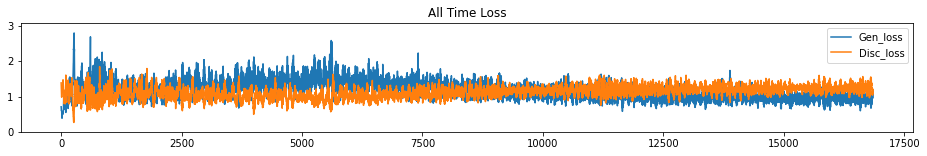

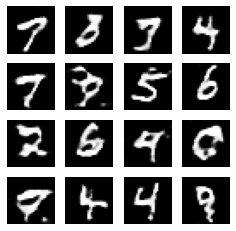

Gen_loss mean= 0.96910036 std= 0.12450859
Disc_loss mean= 1.2480482 std= 0.1214446
Learning rate = 0.0002


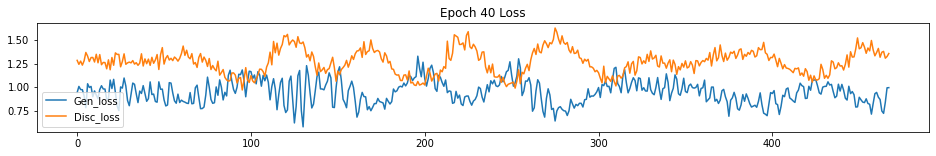

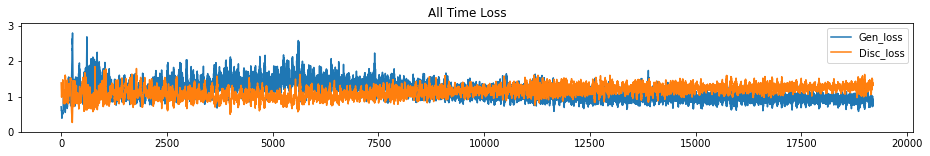

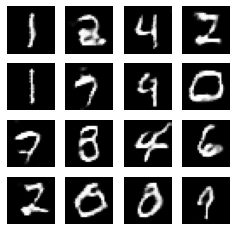

Gen_loss mean= 0.94717574 std= 0.12397123
Disc_loss mean= 1.2678523 std= 0.12776901
Learning rate = 0.0002


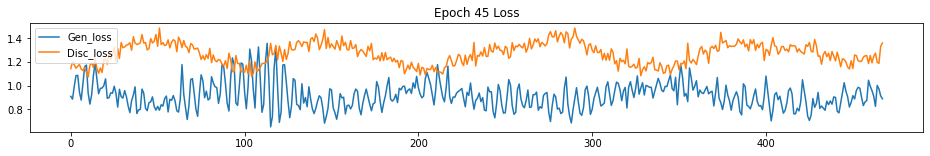

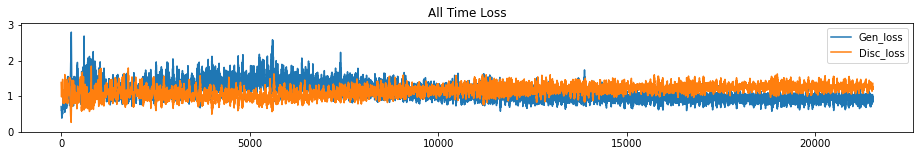

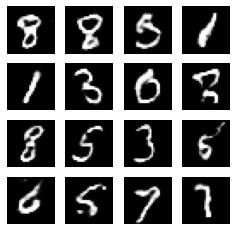

Gen_loss mean= 0.9180008 std= 0.11208531
Disc_loss mean= 1.270138 std= 0.08932119
Learning rate = 0.0002


In [12]:
train(train_data, EPOCHS)

Value = 0
Real Images


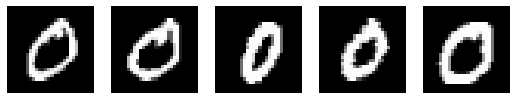

Fake Images


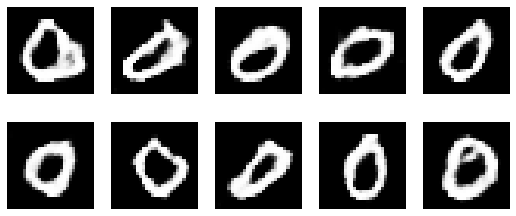

Value = 1
Real Images


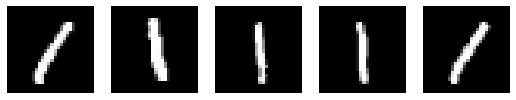

Fake Images


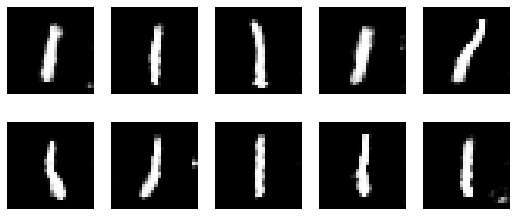

Value = 2
Real Images


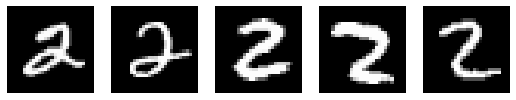

Fake Images


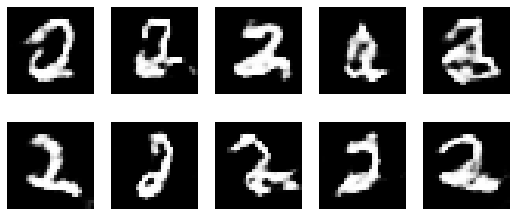

Value = 3
Real Images


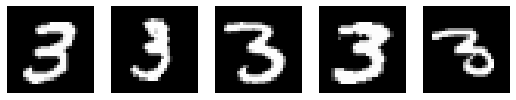

Fake Images


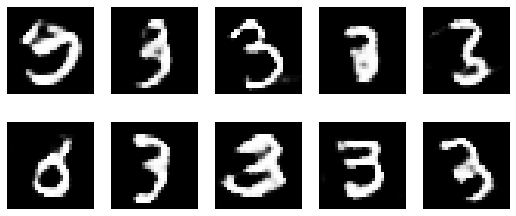

Value = 4
Real Images


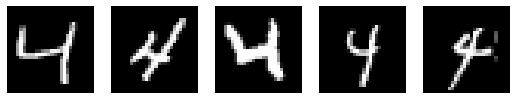

Fake Images


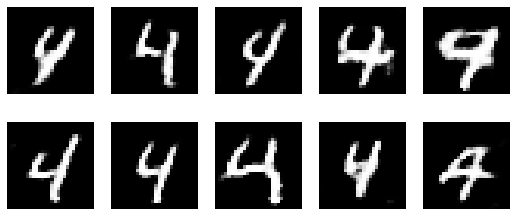

Value = 5
Real Images


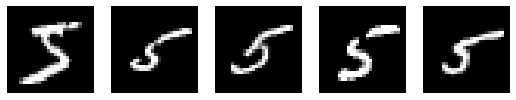

Fake Images


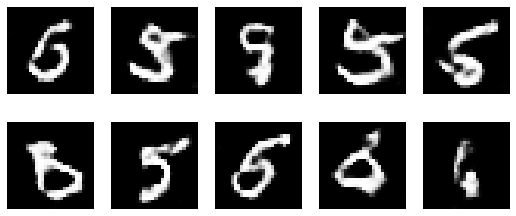

Value = 6
Real Images


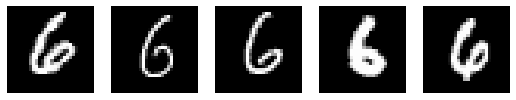

Fake Images


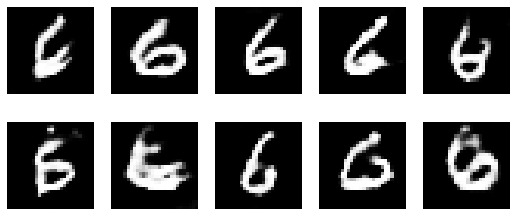

Value = 7
Real Images


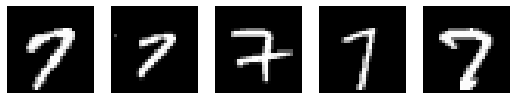

Fake Images


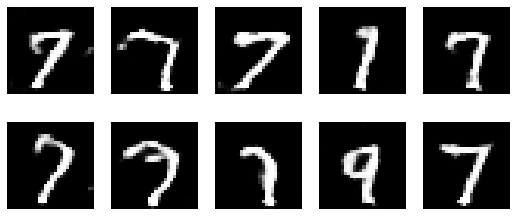

Value = 8
Real Images


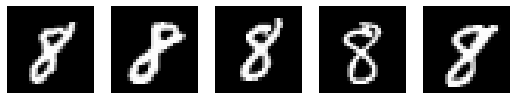

Fake Images


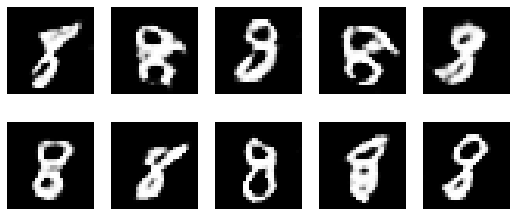

Value = 9
Real Images


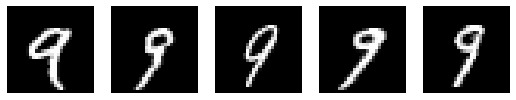

Fake Images


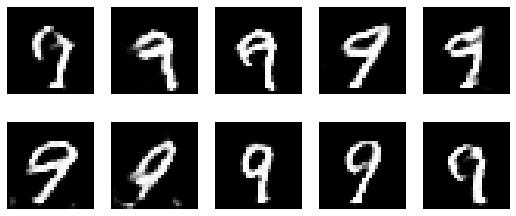

In [22]:
# generator.save("/content/drive/MyDrive/pj2/digit.h5")
model = models.load_model("/content/drive/MyDrive/pj2/digit.h5")
for j in range(10):
    # GENERATE Images
    seed = tf.random.normal([10, noise_dim])
    labs = tf.cast( j*np.ones((10,1)), tf.int8)
    predictions = model([seed, labs], training=False);   
    # GET BREED NAME    
    br = np.argwhere( train_labels.reshape(60000)==j ).flatten()
    # CALCULATE VARIETY
    print("Value =", j)
    plt.figure(figsize=(9,6))
    print("Real Images")
    for i in range(5):
        plt.subplot(3,5,i+1)
        plt.imshow((train_images[br[i],:,:,0]+1.)/2.,cmap ="gray" )
        plt.axis('off')
    plt.show()
    plt.figure(figsize=(9,6))
    print("Fake Images")
    for i in range(10):
        plt.subplot(3,5,i+6)
        plt.imshow( (predictions[i,:,:,0]+1.)/2., cmap ="gray" )
        plt.axis('off')
    plt.show()